# Please only run the final model in the "Put all together" section to save your time!!!

In [113]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model, preprocessing, model_selection 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder,StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer

# The Data

Here's the code to get the data.

In [114]:
data_file = "5th_yr.csv"

In [115]:
# Note the use of *relative path*; your assignments should all use relative rather than absolute paths
DATA_PATH = "./data/midterm_project/bankruptcy/train"

data = pd.read_csv(os.path.join(DATA_PATH, data_file))

In [116]:
data.tail()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
4813,0.21199,0.20585,0.1417,1.7941,72.981,0,0.26531,3.8579,0.9842,0.79415,...,0.26694,0.73275,0.022101,?,3.5081,66.1710,5.516,1.4476,0,1985
4814,0.3119,0.09958,0.57936,10.679,245.98,0,0.31317,9.0422,1.0516,0.90042,...,0.3464,0.70705,0.044114,14.018,7.0618,20.7760,17.568,2.9149,0,3963
4815,-0.029746,0.44898,0.39136,1.9388,7.8073,-0.020006,-0.030561,1.2259,1.0001,0.5504,...,-0.054046,0.99986,0.058336,15.547,8.7022,34.3700,10.62,23.086,0,4167
4816,0.28473,0.079573,0.46261,6.8137,-81.158,-0.79551,0.28473,11.567,6.0718,0.92043,...,0.30935,0.19889,0,?,28.5,4.7834,76.305,13.263,0,1579
4817,0.12009,0.63072,-0.10501,0.81336,-43.226,-0.17492,0.15424,0.5855,3.1990,0.36928,...,0.3252,0.04347,0,12.825,16.441,64.1950,5.6858,5.8982,0,3294


# Data Preprocessing and Features Engineering

### 1.1 Replace all non-numerical data to NaN

***As we know from data table, the missing value in the dataset are "?" instead of np.NaN, the following function is helping us to replace "?" by np.nan***

In [117]:
def isnumber(x):
    try:
        float(x)
        return True
    except:
        return False

data = data[data.applymap(isnumber)]

In [118]:
temp = pd.DataFrame({"data_NULL":data.isnull().sum()})
temp[temp.data_NULL>100].data_NULL

X24     116
X27     305
X37    2068
X45     220
X60     220
Name: data_NULL, dtype: int64

***When we split the data into y_train, and X_train dataset, since X37 has almost missed 50% data, we should drop this feature; and we also need to drop Id feature, because it does not contribute to our result***

### 1.2 Change all string types to float type since they are supposed to be numerical data shown above

***from first 10 columns we can know that some features should be numerical but their type are categorical***

In [119]:
data.iloc[:,:10].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      4816 non-null   object 
 1   X2      4816 non-null   object 
 2   X3      4816 non-null   object 
 3   X4      4803 non-null   object 
 4   X5      4808 non-null   object 
 5   X6      4816 non-null   object 
 6   X7      4816 non-null   object 
 7   X8      4804 non-null   object 
 8   X9      4818 non-null   float64
 9   X10     4816 non-null   object 
dtypes: float64(1), object(9)
memory usage: 376.5+ KB


**Convert categorical to numerical**

In [120]:
data.loc[:, 'X1':'X64']=data.loc[:,'X1':'X64'].apply(lambda x: x.astype(float))

In [121]:
data.iloc[:,:10].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      4816 non-null   float64
 1   X2      4816 non-null   float64
 2   X3      4816 non-null   float64
 3   X4      4803 non-null   float64
 4   X5      4808 non-null   float64
 5   X6      4816 non-null   float64
 6   X7      4816 non-null   float64
 7   X8      4804 non-null   float64
 8   X9      4818 non-null   float64
 9   X10     4816 non-null   float64
dtypes: float64(10)
memory usage: 376.5 KB


### 2. Clean and Transform data

In [122]:
y_train = data['Bankrupt']

# delete X37, since we miss about half data
df = data.copy()
data.drop(columns=['X37','Id','Bankrupt'],inplace=True)

**Add one new features that calculate the number of missing data of each company, it's most likely that if a company miss more data, it may go bankrupt**

In [123]:
data['missing'] = df.isnull().sum(axis=1)

**Scaling the data such that some features have much larger or smaller values that others**

In [124]:
data.describe(include='all') # for scaling

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,missing
count,4816.000000,4816.000000,4816.000000,4803.000000,4.808000e+03,4816.000000,4816.000000,4804.000000,4818.000000,4816.000000,...,4818.000000,4816.000000,4818.000000,4816.000000,4.598000e+03,4806.000000,4818.000000,4803.000000,4735.000000,4818.000000
mean,-0.055232,0.533272,0.188992,4.978602,1.956441e+01,-0.070060,-0.042516,5.739985,1.579277,0.503606,...,0.056109,0.022793,0.959585,0.273025,1.108795e+03,11.021303,177.494445,9.287631,38.557533,0.776671
std,6.707351,1.202909,1.282430,100.273952,2.384491e+04,7.778523,6.707970,109.508001,1.342723,4.044036,...,0.755462,7.249022,0.932427,6.338601,7.106563e+04,43.821146,2279.713700,113.225922,588.711967,1.488848
min,-463.890000,0.000000,-72.067000,0.000000,-1.076400e+06,-463.890000,-463.890000,-3.735100,0.000191,-71.444000,...,-46.788000,-468.670000,-0.085920,-184.980000,-1.244000e+01,-0.092493,0.000000,0.000000,-3.726500,0.000000
25%,0.004047,0.254670,0.044923,1.099200,-4.312000e+01,0.000000,0.005985,0.481588,1.015600,0.318990,...,0.011478,0.015574,0.876940,0.000000,5.298300e+00,4.229925,45.065750,3.074350,2.114850,0.000000
50%,0.046487,0.451495,0.218560,1.642300,3.673450e-01,0.000000,0.056685,1.149000,1.140500,0.522325,...,0.053663,0.108940,0.950825,0.006320,9.038900e+00,6.176800,73.879500,4.928700,4.077200,0.000000
75%,0.116730,0.662177,0.420153,2.929200,4.986775e+01,0.110470,0.136025,2.781300,1.814050,0.721823,...,0.124030,0.240262,0.990358,0.206915,1.720750e+01,9.302800,118.597500,8.067850,9.187600,1.000000
max,2.352300,72.416000,28.336000,6845.800000,1.250100e+06,203.150000,2.352300,6868.500000,37.807000,266.860000,...,1.000000,87.981000,47.788000,308.150000,4.818700e+06,1308.500000,127450.000000,7641.300000,28999.000000,32.000000


***As we can seet that, X62's maximum value is 127450, while some features' max are less than 100, so data scaling is needed, I alway use KNNImpute for missing data this time which is more reasonable than imputation as median or mean***

In [125]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X): 
        return X[self.attribute_names]

num_features = data.columns.tolist()[:64]
num_pipeline = Pipeline([("select_numeric", DataFrameSelector(num_features)),
                        ("imputer", KNNImputer(n_neighbors=20)),
                         ("scaling",StandardScaler())])

In [126]:
X_train = num_pipeline.fit_transform(data)

### 4. PCA

In [127]:
from sklearn.decomposition import PCA

In [128]:
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train)

In [129]:
X_train_pca.shape

(4818, 30)

In [130]:
pca.explained_variance_ratio_

array([0.23, 0.18, 0.12, 0.05, 0.04, 0.03, 0.03, 0.03, 0.03, 0.03, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  ])

***From here we know that we n-components is equal to 30***

In [131]:
pca = PCA(n_components=X_train_pca.shape[1])
X_train = pca.fit_transform(X_train)

### 5. Fix imbalance problem

#### checking Bankrupt following, we find out that the data of Bankrupt is so much imbalanced, the ratio is about 94:6, so rebalance is required in this dataset

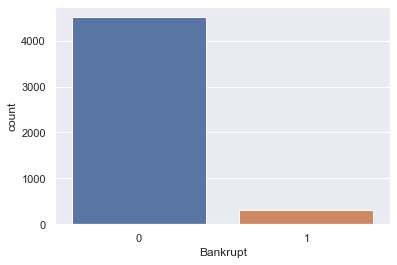

In [132]:
sns.set(style="darkgrid")
ax = sns.countplot(x='Bankrupt',data=df)

In [133]:
print(df[df.Bankrupt == 0].Bankrupt.count())
print(df[df.Bankrupt == 1].Bankrupt.count())

4510
308


In [134]:
print(df[df.Bankrupt == 0].Bankrupt.count()/df.Bankrupt.count())
print(df[df.Bankrupt==1].Bankrupt.count()/df.Bankrupt.count())

0.9360730593607306
0.0639269406392694


***Since our dataset is not large, I choose over sampling method to fix the imbalance by using SMOTE function***

In [135]:
from imblearn.over_sampling import SMOTE

In [136]:
sm = SMOTE(random_state=12)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [137]:
print(y_train.shape)
print(X_train.shape)
print(y_train[y_train==0].count())
print(y_train[y_train==1].count())

(9020,)
(9020, 30)
4510
4510


***As we can see that the number of minority Bankrupt == 1 is equal to 4510, and total number of examples are 9020***

### 6.Fit in proper model

**I chose random forest because it builds multiple decision trees and merges them together to get a more accurate and stable prediction, we have 63 features in this cases, I believe rf can give us more accurate results**

In [138]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train,y_train)
scores = cross_val_score(rf, X_train,y_train, cv=5)
model = "Random forest"
cross_val_avg = np.mean(scores)

print("{m:s}: Avg cross val score = {sc:3.6f}".format(m=model, sc=cross_val_avg) )

Random forest: Avg cross val score = 0.954989


In [139]:
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Random forest: Accuracy = 0.954989
Recall metric in the testing dataset:  0.9767184035476718


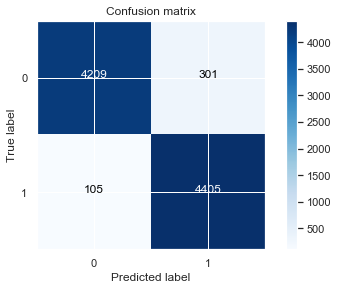

In [140]:
predictions = cross_val_predict(rf, X_train, y_train, cv=5)
cm = confusion_matrix(y_train, predictions)
accuracy = (cm[0][0]+cm[1][1])/cm.sum()
print("{m:s}: Accuracy = {a:.6f}".format(m=model, a=accuracy))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train,predictions)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

### 1.2 Change all string types to float type since they are numerical data shown above

### 7.Fine tune

**Choose the proper n_estimators and max_depth for random forest (I already ran many times, below is the best example)**

In [141]:
parameters = [{"criterion": ["gini", "entropy"],"n_estimators":[50, 100, 150],"max_depth":[20, 30, 40]}]
"""parameters = { "criterion" : ["gini", "entropy"], 
              "min_samples_leaf" : [1, 5, 10, 25, 50, 70], 
              "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], 
              "n_estimators":[10,20,40,60,80,100,120,140,160],
              "max_depth":[3,4,5,6,7,8,9,10]}"""
grid_search = GridSearchCV(estimator = rf,
                          param_grid = parameters,
                          scoring = 'accuracy',
                          cv = 5,
                          n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters =  grid_search.best_params_
print('the best accuracy is {0}, and best parameters are {1}'.format(best_accuracy,best_parameters))

the best accuracy is 0.9562084257206209, and best parameters are {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 100}


In [142]:
rf = RandomForestClassifier(criterion='gini',max_depth=20, n_estimators=100, random_state=42)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

**Change the shreshold of the model and customize our cost function for extra credit**

In [143]:
from sklearn.metrics import precision_recall_curve 
y_scores = rf.predict_proba(X_train)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

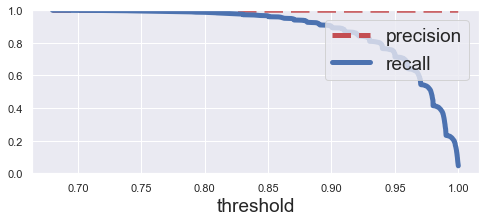

In [144]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores = rf.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r--", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 3))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

**Here we design our cost function in order to choose the best threshold**

In [145]:
y_scores = rf.predict_proba(X_train)

threshold = np.arange(0,1,0.01)
cost = []

for i in range(100):
    y_pred = (y_scores[:,1] >= threshold[i]).astype('int')
    false_positive = confusion_matrix(y_train, y_pred)[1,0]
    false_negative = confusion_matrix(y_train, y_pred)[0,1]
    cost.append(100*false_positive + 500*false_negative) # false negative is worse 5 times than false positive

ind = np.where(cost == min(cost))
thred = threshold[ind[0]]

In [146]:
thred

array([0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57,
       0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68])

***As we can see that, thred contains 0.5, so actually we can use default threshold as 0.5***

In [147]:
thred = 0.5

## Put all together

In [148]:
data_file = "5th_yr.csv"
DATA_PATH = "./data/midterm_project/bankruptcy/train"
data = pd.read_csv(os.path.join(DATA_PATH, data_file))

In [149]:
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import NearMiss
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.combine import SMOTEENN

In [150]:
y_train = data['Bankrupt']
data.drop(columns=['X37','Bankrupt','Id'],inplace=True)
data['missing'] = df.isnull().sum(axis=1)

In [151]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X): 
        return X[self.attribute_names]

def isnumber(x):
    try:
        float(x)
        return True
    except:
        return False

class isNumber(BaseEstimator,TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        return X[X.applymap(isnumber)]
        

class StrToFloat(BaseEstimator, TransformerMixin):
    def fit(self,X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.astype(float)
        return X

num_features = data.columns.tolist()[:64]
num_pipeline = Pipeline(steps=[("select_numeric", DataFrameSelector(num_features)),
                         ("toNaN", isNumber()),
                         ("toFloat",StrToFloat()),
                        ("imputer", KNNImputer(n_neighbors=5)),
                         ("scaling",StandardScaler())])

In [152]:
X_train = num_pipeline.fit_transform(data)
pca = PCA(n_components=30)
X_train = pca.fit_transform(X_train)
sm = SMOTE(random_state=12)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [153]:
rf = RandomForestClassifier(criterion='gini',max_depth=20, n_estimators=100, random_state=42)
rf.fit(X_train,y_train)

thred = 0.5

scores = cross_val_score(rf, X_train,y_train, cv=5)
model = "Random forest"
cross_val_avg = np.mean(scores)

print("{m:s}: Avg cross val score = {sc:3.6f}".format(m=model, sc=cross_val_avg) )

Random forest: Avg cross val score = 0.956652


## Finally, Create MyModel and Output Predictions

In [154]:
def isnumber(x):
    try:
        float(x)
        return True
    except:
        return False

def MyModel(fileName):
    TEST_PATH = "./data/midterm_project/bankruptcy/holdout"
    testFileName = os.path.join(TEST_PATH, data_file)
    
    # Get data
    X_test = pd.read_csv(testFileName)
    
    # Replace all missing data symbol to NaN
    X_test = X_test[X_test.applymap(isnumber)]
    
    # Change all string type data to numerical data
    X_test.loc[:, 'X1':'X64']=X_test.loc[:,'X1':'X64'].apply(lambda x: x.astype(float))
    
    # Drop X37
    X_test.drop(columns=['X37','Id'],inplace=True)
    
    # Add new features: missing data of each firm
    X_test['missing'] = X_test.isnull().sum(axis=1)
    
    # Transform via num_Pipeline
    X_test = num_pipeline.fit_transform(X_test)
    
    # Decompose PCA:
    X_test = pca.fit_transform(X_test)
    
    # Fit and predit:
    y_pred_score = rf.predict_proba(X_test)
    y_pred = (y_pred_score[:,1] >= thred).astype('int')
    
    # Fit in model:
    return y_pred

In [155]:
y_pred = MyModel("5th_yr.csv")

In [156]:
print(np.sum(y_pred == 0))
print(np.sum(y_pred == 1))

1090
2


In [157]:
print("Done!")

Done!
